## Bibliotecas necessárias

In [1]:
# Importação de Bibliotecas Necessárias
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D,MaxPooling1D
from tensorflow.keras.utils import to_categorical
import soundata
import tensorflow as tf
import os
import librosa
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

2023-12-03 14:44:07.195805: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 14:44:07.352717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 14:44:07.353822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 14:44:08.329251: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Extração de features e download dos sons

In [2]:
dfclass = pd.read_csv(r'UrbanSound8K.csv')
dfclass.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
FOLDS_PATH = "../urbansound8k/audio"
DURATION = 4 # 4 seconds for each audio file
SAMPLE_RATE = 22050
HOP_LENGTH = round(SAMPLE_RATE * 0.0125)
WIN_LENGTH = round(SAMPLE_RATE * 0.023)
N_FFT = 2**10
TIME_SIZE = 4*SAMPLE_RATE//HOP_LENGTH+1

In [4]:
def load_fold_data(features_file, labels_file, label_encoder):
    features = pd.read_csv(features_file).values
    labels = pd.read_csv(labels_file)['0']
    encoded_labels = label_encoder.transform(labels)
    return features, encoded_labels

In [5]:
def create_label_mapping(folds_path, n_folds):
    all_labels = set()
    for fold_number in range(1, n_folds + 1):
        labels_file = f'../csv/labels_fold{fold_number}.csv'
        df_labels = pd.read_csv(labels_file)
        all_labels.update(df_labels['0'].unique())
    
    label_encoder = LabelEncoder()
    label_encoder.fit(list(all_labels))
    return label_encoder


In [22]:
import os
import librosa
import numpy as np
import pandas as pd

def load_data():
    for fold in range(1, 11):
        features = []
        labels = []
        fold_path = os.path.join(FOLDS_PATH, f'fold{fold}')
        audio_files = librosa.util.find_files(fold_path)

        for audio_file_path in audio_files:
            # Carregar o arquivo de áudio
            audio_data, sample_rate = librosa.load(audio_file_path)
            audio_data = librosa.util.fix_length(audio_data, size=int(4 * 22050))
            
            mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            
            chroma = librosa.feature.chroma_stft(y=audio_data, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
            mfccs_mean = np.mean(mfccs.T, axis=0)  # Média dos MFCCs ao longo do tempo

            # Combinar as características

            # Adicionar características à lista
            features.append(mfccs_mean)
            features.append(mel_spec)
            features.append(chroma)

            # Obter rótulo para o arquivo de áudio
            audio_file = os.path.basename(audio_file_path)
            label = dfclass.loc[dfclass['slice_file_name'] == audio_file, 'class'].iloc[0]
            labels.append(label)

        # Salvar características e rótulos em CSV
        features_df = pd.DataFrame(features)
        features_df.to_csv(f'../csv/features_fold{fold}.csv', index=False)
        labels_df = pd.DataFrame(labels)
        labels_df.to_csv(f'../csv/labels_fold{fold}.csv', index=False)
        print(f"Fold {fold} processado e salvo.")
load_data()

KeyboardInterrupt: 

## Vamos observar cada fold em particular

In [6]:
def analyze_fold(fold_number):
    # Carregar características e rótulos do fold específico
    features_path = f"../csv/features_fold{fold_number}.csv"
    labels_path = f"../csv/labels_fold{fold_number}.csv"
    df_labels = pd.read_csv(labels_path)

    # Adicionar os rótulos ao DataFrame das características
    

    # Observar rótulos únicos
    unique_labels = df_labels['0'].unique()
    print(f"Etiquetas únicas no conjunto de dados do fold {fold_number}: {unique_labels}\n")

for i in range(1,11):
    analyze_fold(i)

Etiquetas únicas no conjunto de dados do fold 1: ['dog_bark' 'gun_shot' 'jackhammer' 'engine_idling' 'children_playing'
 'siren' 'street_music' 'air_conditioner' 'drilling' 'car_horn']

Etiquetas únicas no conjunto de dados do fold 2: ['dog_bark' 'engine_idling' 'siren' 'drilling' 'children_playing'
 'air_conditioner' 'car_horn' 'street_music' 'gun_shot' 'jackhammer']

Etiquetas únicas no conjunto de dados do fold 3: ['dog_bark' 'drilling' 'engine_idling' 'gun_shot' 'car_horn' 'siren'
 'children_playing' 'air_conditioner' 'street_music' 'jackhammer']

Etiquetas únicas no conjunto de dados do fold 4: ['dog_bark' 'street_music' 'jackhammer' 'siren' 'car_horn' 'engine_idling'
 'drilling' 'gun_shot' 'children_playing' 'air_conditioner']

Etiquetas únicas no conjunto de dados do fold 5: ['dog_bark' 'children_playing' 'air_conditioner' 'jackhammer'
 'street_music' 'engine_idling' 'siren' 'drilling' 'car_horn' 'gun_shot']

Etiquetas únicas no conjunto de dados do fold 6: ['dog_bark' 'children

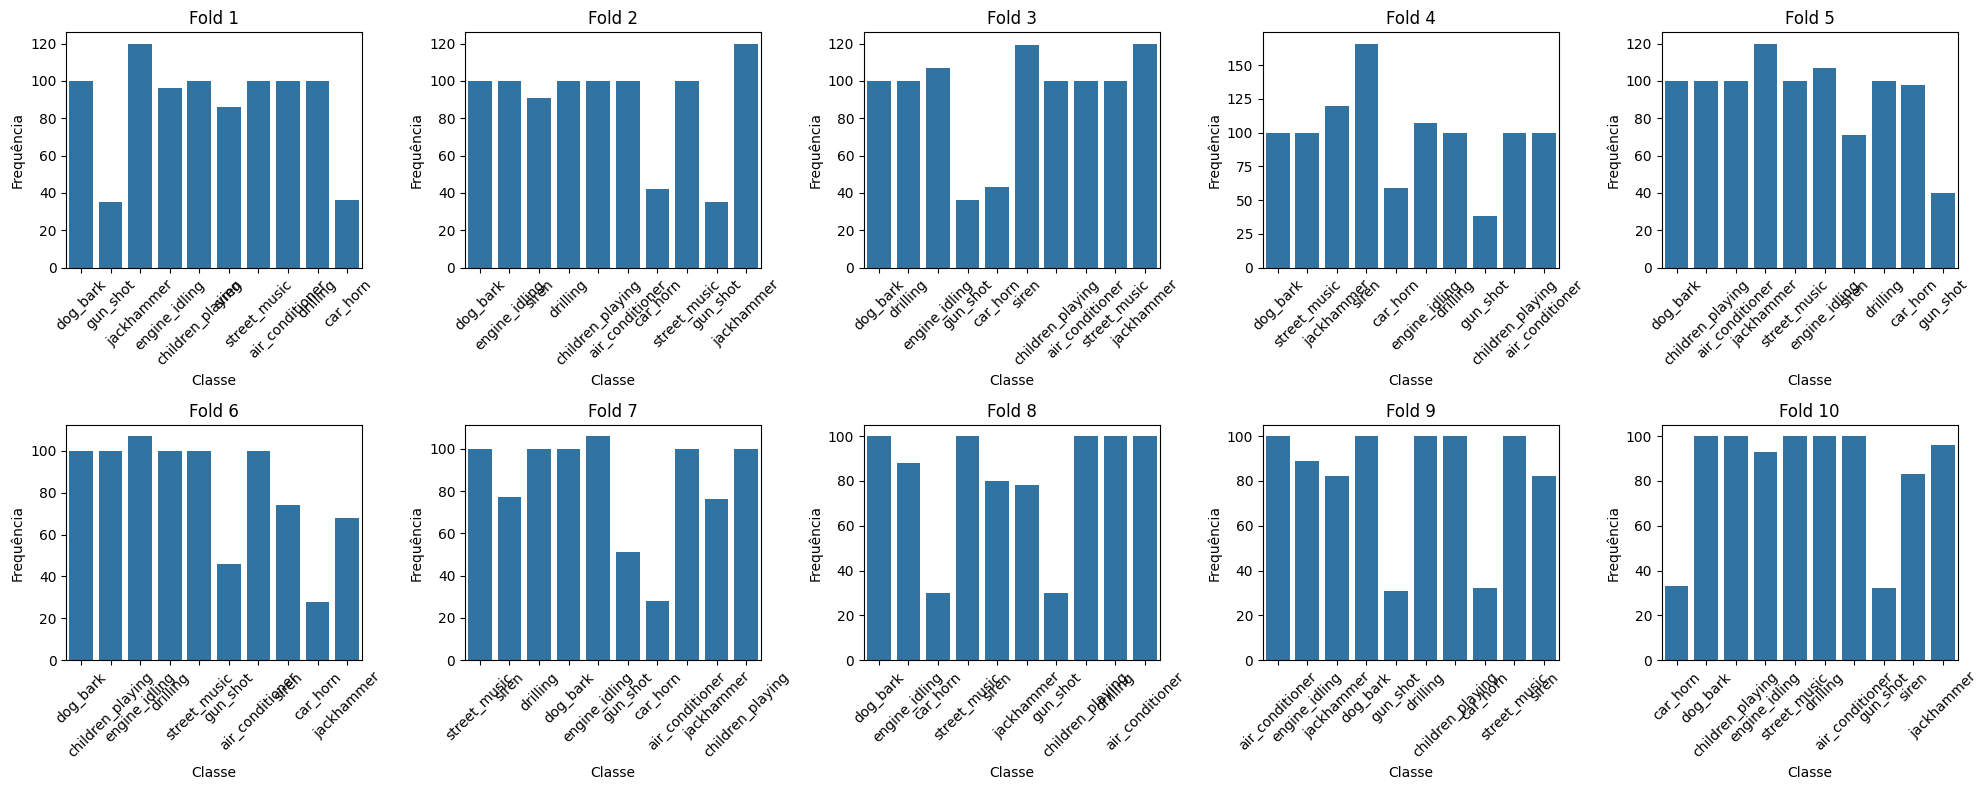

In [7]:
def plot_label_distribution_all_folds(n_folds):
    # Número de linhas e colunas para os subplots
    nrows = 2
    ncols = 5

    # Configurar o layout para os subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))  # Ajuste o tamanho conforme necessário

    for fold_number in range(1, n_folds + 1):
        # Carregar os rótulos do fold específico
        labels_path = f"../csv/labels_fold{fold_number}.csv"
        df_labels = pd.read_csv(labels_path)

        # Determinar a posição do subplot
        row = (fold_number - 1) // ncols
        col = (fold_number - 1) % ncols

        # Plotar o gráfico no subplot correspondente
        sns.countplot(x=df_labels['0'], ax=axes[row, col])
        axes[row, col].set_title(f'Fold {fold_number}')
        axes[row, col].set_xlabel('Classe')
        axes[row, col].set_ylabel('Frequência')
        axes[row, col].tick_params(axis='x', rotation=45)

    # Ajustar o layout e exibir a figura
    plt.tight_layout()
    plt.show()

# Exemplo de uso para todos os 10 folds
plot_label_distribution_all_folds(10)

KeyboardInterrupt: 

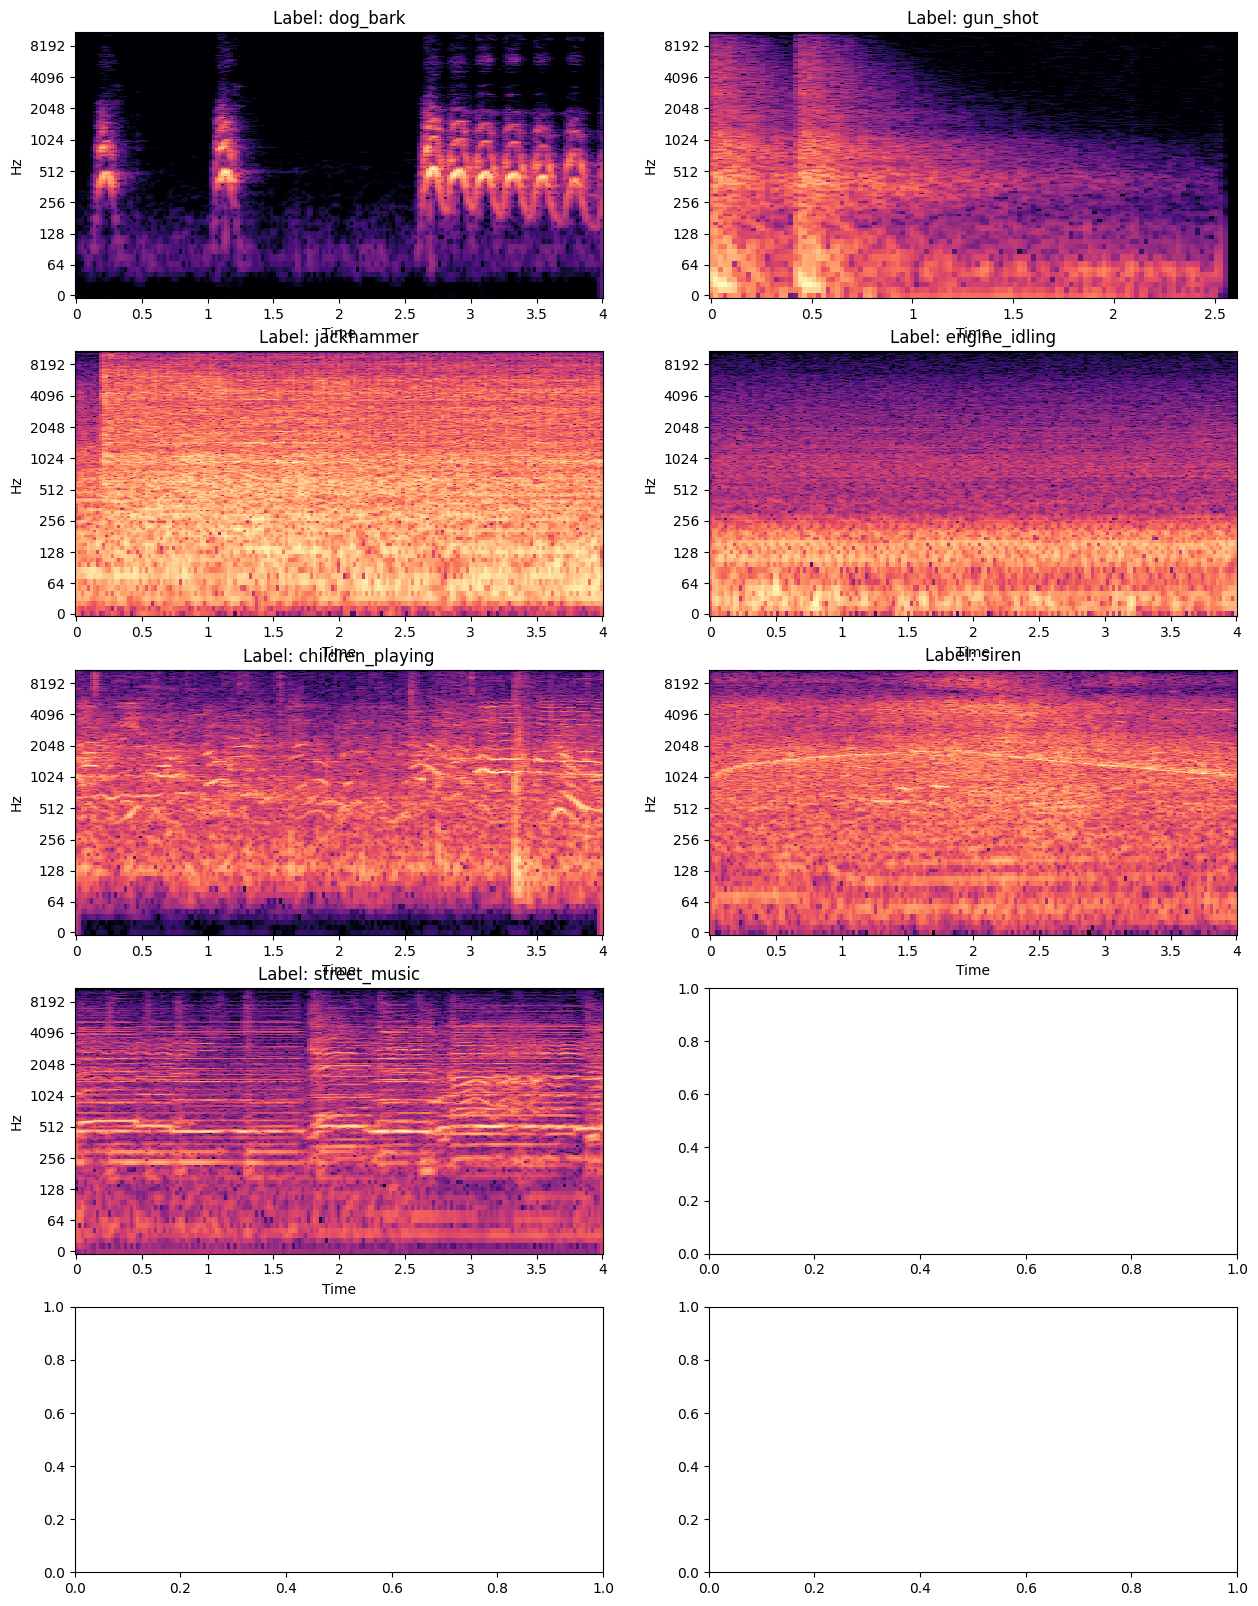

In [8]:
# Preparando o layout para os subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))  #tamanho dos subplots
axes = axes.flatten()  # array unidimensional
processed_labels = set()
label_count = 0

folds = [fold for fold in os.listdir(FOLDS_PATH) if "fold" in fold]
for fold in folds:
    audio_files = librosa.util.find_files(FOLDS_PATH+"/"+fold)
    features = []
    labels = []
    for audio_file_path in audio_files:

        # Carregar o arquivo de áudio
        audio_data, sample_rate = librosa.load(audio_file_path)
        audio_file = audio_file_path.split("/")[-1]
        label=dfclass.loc[dfclass['slice_file_name'] == audio_file, 'class'].iloc[0]

        if label not in processed_labels:
            processed_labels.add(label)

            # Meter grafico no subplot correspondente
            librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max), 
                                     sr=sample_rate, 
                                     x_axis='time', 
                                     y_axis='log', 
                                     ax=axes[label_count])
            axes[label_count].set_title(f'Label: {label}') 
            label_count += 1
            if label_count >= 10:  # Se já tiver os 10 graficos
                break

plt.tight_layout()
plt.show()

## K-Fold Cross Validation

### Para a CNN

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
def kfoldcnn(n_folds, label_encoder):
    accuracies = []
    conf_matrices = []
    all_histories = []
    scaler = StandardScaler()

    for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            model=createmodel()
            features_file = f'../csv/features_fold{fold}.csv'
            labels_file = f'../csv/labels_fold{fold}.csv'
            features, encoded_labels = load_fold_data(features_file, labels_file, label_encoder)

            if fold == test_fold:
                X_test, y_test = features, encoded_labels
            else:
                X_train.append(features)
                y_train.append(encoded_labels)

        # Concatenar e preparar os dados de treino
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        
        print("ai")
        # Dividir o conjunto de teste em validação e teste
        X_val, X_test_final, y_val, y_test_final = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        print("ai")
        
        # Normalizar os dados
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)
        X_test_final = scaler.fit_transform(X_test_final)

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train)
        y_val_categorical = to_categorical(y_val)
        y_test_final_categorical = to_categorical(y_test_final)

        # Construir, compilar e treinar o modelo
        print(X_train.shape)
        print(X_val.shape)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        hist = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_data=(X_val, y_val_categorical))
        all_histories.append(hist.history)

        # Avaliação do modelo no conjunto de teste final
        test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final_categorical)
        accuracies.append(test_accuracy)

        # Previsão e matriz de confusão
        y_pred = model.predict(X_test_final)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_final_categorical, axis=1)
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)

    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print("Matriz de Confusão Média:\n", mean_conf_matrix)
    print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")

    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy


### Para o MLP

In [15]:
def kfoldmlp(n_folds, label_encoder, num_classes):
    accuracies = []
    conf_matrices = []
    all_histories = []
    scaler = StandardScaler()

    for test_fold in range(1, n_folds + 1):
        X_train, y_train = [], []
        for fold in range(1, n_folds + 1):
            features_file = f'../csv/features_fold{fold}.csv'
            labels_file = f'../csv/labels_fold{fold}.csv'
            features, encoded_labels = load_fold_data(features_file, labels_file, label_encoder)

            if fold == test_fold:
                X_test, y_test = features, encoded_labels
            else:
                X_train.append(features)
                y_train.append(encoded_labels)

        # Concatenar e preparar os dados de treino
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        
        X_train = X_train.reshape((X_train.shape[0], -1))
        X_test = X_test.reshape((X_test.shape[0], -1))

        # Normalizar os dados
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Conversão para formato categórico
        y_train_categorical = to_categorical(y_train, num_classes=num_classes)
        y_test_categorical = to_categorical(y_test, num_classes=num_classes)

        # Construir, compilar e treinar o modelo
        hist = modelMLP.fit(X_train, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_test, y_test_categorical), verbose=0)
        all_histories.append(hist.history)

        # Avaliação do modelo
        test_loss, test_accuracy = modelMLP.evaluate(X_test, y_test_categorical)
        y_pred = modelMLP.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        
        conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
        conf_matrices.append(conf_mat)
        accuracies.append(test_accuracy)

    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print("Matriz de Confusão Média:\n", mean_conf_matrix)
    print(f"Acurácia média: {mean_accuracy:.2f}, Desvio padrão: {std_accuracy:.2f}")

    return all_histories, mean_conf_matrix, mean_accuracy, std_accuracy


## Primeiro Modelo Convulsional Neural Network

### Definir a arquitetura:

##### Camadas Conv1D: Duas camadas convolucionais com 64 e 128 filtros, respectivamente, e kernels de tamanho 3. Essas camadas são responsáveis por extrair características relevantes dos dados de áudio.

##### Camadas MaxPooling1D: Seguindo cada camada convolucional, estas camadas reduzem a dimensionalidade dos dados, o que ajuda a diminuir a complexidade computacional e a combater o overfitting.

##### Camada Flatten: Transforma os dados de uma forma multidimensional para um vetor unidimensional, preparando-os para a próxima etapa de processamento.

##### Camada Densa e Dropout: Uma camada densa com 128 neurônios é seguida por uma camada de dropout que ajuda a prevenir o overfitting ao descartar aleatoriamente parte dos sinais.

##### Camada de Saída: Uma camada densa com uma função de ativação 'softmax', utilizada para a classificação multiclasse. O número de neurônios nesta camada corresponde ao número de classes a serem previstas.

### Compilação do Modelo

##### O modelo é compilado com o otimizador 'adam' e a função de perda 'categorical_crossentropy', com 'accuracy' como métrica de desempenho. Este setup é padrão para problemas de classificação multiclasse.

In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


def createmodel():
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(407,1), kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(32, 3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model




In [17]:
import keras
keras.utils.plot_model(model, 'CNN.png', show_shapes=True)

NameError: name 'model' is not defined

### K-Fold Cross Validation com os folds predefenidos 

In [ ]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)

all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfoldcnn(10,label_encoder)

In [7]:
average_history = {
    'loss': np.mean([x['loss'] for x in all_histories], axis=0),
    'accuracy': np.mean([x['accuracy'] for x in all_histories], axis=0),
    'val_loss': np.mean([x['val_loss'] for x in all_histories], axis=0),
    'val_accuracy': np.mean([x['val_accuracy'] for x in all_histories], axis=0),
}

print(len(average_history['val_accuracy']))

# Plotar os gráficos
epochs = range(1, 6)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, average_history['loss'], 'co', label='Training Loss')
ax1.plot(epochs, average_history['val_loss'], 'm', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, average_history['accuracy'], 'co', label='Training Accuracy')
ax2.plot(epochs, average_history['val_accuracy'], 'm', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

NameError: name 'all_histories' is not defined

## Segundo Modelo: Multi-Layer Perceptron

In [383]:
modelMLP = Sequential()
modelMLP.add(Dense(256, activation='relu', input_shape=(407,1)))
modelMLP.add(Dropout(0.1))
modelMLP.add(Dense(128, activation='relu'))
modelMLP.add(Dropout(0.1))
modelMLP.add(Dense(10, activation='softmax'))

modelMLP.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

modelMLP.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 407, 256)          512       
                                                                 
 dropout_109 (Dropout)       (None, 407, 256)          0         
                                                                 
 dense_115 (Dense)           (None, 407, 128)          32896     
                                                                 
 dropout_110 (Dropout)       (None, 407, 128)          0         
                                                                 
 dense_116 (Dense)           (None, 407, 10)           1290      
                                                                 
Total params: 34,698
Trainable params: 34,698
Non-trainable params: 0
_________________________________________________________________


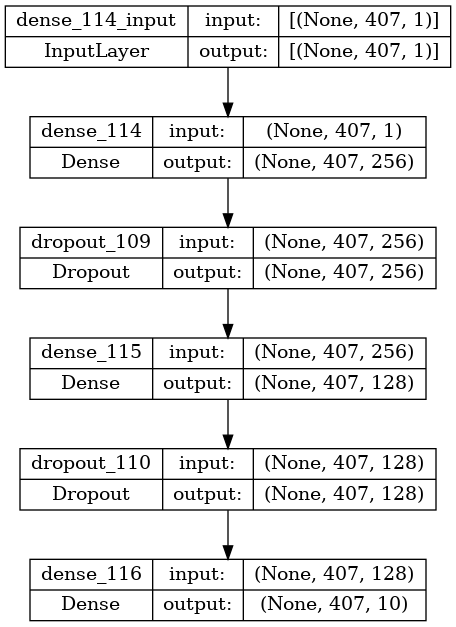

In [384]:
keras.utils.plot_model(modelMLP, 'MLP.png', show_shapes=True)

In [386]:
n_folds = 10
accuracies = []
conf_matrices = []
all_histories = []

label_encoder = create_label_mapping(FOLDS_PATH, n_folds)
all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfoldmlp(n_folds, label_encoder, 10)

2023-11-27 19:35:26.491751: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [32 10] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [32 407]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/guilherme/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/guilherme/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/guilherme/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/home/guilherme/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/guilherme/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/home/guilherme/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/home/guilherme/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/home/guilherme/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/home/guilherme/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/home/guilherme/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/guilherme/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/guilherme/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/guilherme/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/guilherme/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/guilherme/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/guilherme/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_11372/2271149455.py", line 7, in <module>
      all_histories, mean_conf_matrix, mean_accuracy, std_accuracy=kfoldmlp(n_folds, label_encoder, 10)
    File "/tmp/ipykernel_11372/2348820140.py", line 36, in kfoldmlp
      hist = modelMLP.fit(X_train, y_train_categorical, epochs=25, batch_size=32, validation_data=(X_test, y_test_categorical), verbose=0)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/home/guilherme/.local/lib/python3.8/site-packages/keras/backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert'
assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [32 10] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [32 407]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert}}]] [Op:__inference_train_function_2358693]

In [ ]:
average_history = {
    'loss': np.mean([x['loss'] for x in all_histories], axis=0),
    'accuracy': np.mean([x['accuracy'] for x in all_histories], axis=0),
    'val_loss': np.mean([x['val_loss'] for x in all_histories], axis=0),
    'val_accuracy': np.mean([x['val_accuracy'] for x in all_histories], axis=0),
}


# Plotar os gráficos
epochs = range(1, 26)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, average_history['loss'], 'co', label='Training Loss')
ax1.plot(epochs, average_history['val_loss'], 'm', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, average_history['accuracy'], 'co', label='Training Accuracy')
ax2.plot(epochs, average_history['val_accuracy'], 'm', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()